- CAM(Class Activation Map)을 얻기 위한 방법 중 기본 CAM과 Grad-CAM을 구현, 시각화
- CAM을 활용해서 물체의 위치를 찾는 object detection을 수행하고 이를 정답 데이터와 비교

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

2024-07-05 03:39:59.042258: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-05 03:40:06.495658: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices('GPU')

2024-07-05 03:40:40.100832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-05 03:40:40.106507: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-05 03:40:40.106538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

2024-07-05 03:40:40.191626: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-05 03:40:40.191685: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-05 03:40:40.191702: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-05 03:40:40.321215: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-05 03:40:40.321254: I external/local_xla/xla/stream_executor

2024-07-05 03:40:41.197460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


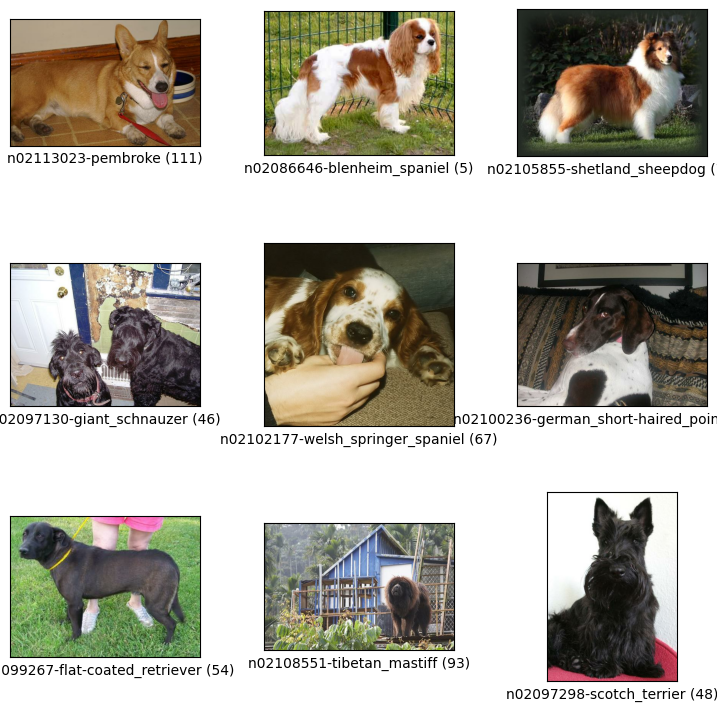

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})

In [4]:
tfds.show_examples(ds_train, ds_info)
ds_info.features

In [5]:
# cam 구현, resnet50 사용
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)


In [6]:
# cam_model.summary()

In [7]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


2024-07-05 03:40:43.759909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [10]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    # use_multiprocessing=True,
)

Epoch 1/2


I0000 00:00:1720150849.810890   90487 service.cc:145] XLA service 0x7f069c003410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720150849.810932   90487 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-07-05 03:40:50.549879: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-05 03:40:51.987093: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1720150861.113716   90487 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.2869 - loss: 3.1607 - val_accuracy: 0.2643 - val_loss: 2.9738
Epoch 2/2


2024-07-05 03:41:24.246054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-05 03:41:24.246301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 4.8588


2024-07-05 03:41:26.048746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-05 03:41:26.048845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


In [11]:
# 학습시킨 모델의 가중치 저장
import os

# history_cam_model.save_weights('./model/cam_model.h5')

# CAM 생성 시작

In [36]:
# CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑음
def get_one(ds):
    ds = ds.take(1) # 
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


2024-07-05 06:00:22.471767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


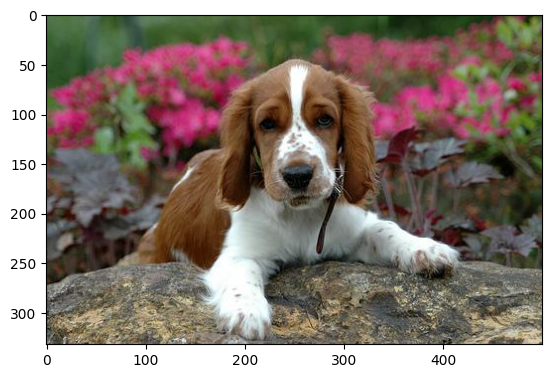

In [37]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [14]:
# 모델 불러오기
cam_model = tf.keras.models.load_model('./model/cam_model.h5')

/data/.venv/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [15]:
# cam_model.summary()
# 아래 코드는 주피터 노트북에서는 작동하지 않음 .py에서 되는걸 확인
'''
# 모델의 마지막 5개 레이어만 출력
import io
from contextlib import redirect_stdout

# 모델 요약을 문자열로 저장
stream = io.StringIO()
with redirect_stdout(stream):
    base_model.summary()
summary_str = stream.getvalue()

# 요약의 마지막 num_print줄만 출력
# um_print줄이 정확하게 나오지는 않음, 대략적으로
num_print = 4
print("\n".join(summary_str.split("\n")[-4*num_print:]))

'''

'\n# 모델의 마지막 5개 레이어만 출력\nimport io\nfrom contextlib import redirect_stdout\n\n# 모델 요약을 문자열로 저장\nstream = io.StringIO()\nwith redirect_stdout(stream):\n    base_model.summary()\nsummary_str = stream.getvalue()\n\n# 요약의 마지막 num_print줄만 출력\n# um_print줄이 정확하게 나오지는 않음, 대략적으로\nnum_print = 4\nprint("\n".join(summary_str.split("\n")[-4*num_print:]))\n\n'

In [25]:
# cam 모델 정의
# (1) 특성 맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 (3) 원하는 클래스의 출력값이 필요
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # -3은 뒤에서 3번째, conv5_block3_out: Activation 레이어 (1) 특성 맵
    cam_model = tf.keras.models.Model(model.inputs, [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0)) # cam_model에 데이터 넣어 predict, 배치 차원 추가 (1,24,24,3)이 됨 -> (1,7,7,2048) 반환
    conv_outputs = conv_outputs[0, :, :, :] # 배치 차원 제거 (7,7,2048)
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    #  (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치 (차원수, 다음 레이어의 노드 수) -> (2048, 120)
    class_weights = model.layers[-1].get_weights()[0] 
    
    # conv_outputs 텐서의 첫 번째와 두 번째 차원의 크기(shape)만큼의 영행렬을 만듦
    # (7,7,2048) -> (7,7)
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2]) 
    for i, w in enumerate(class_weights[:, class_idx]): # 예측된 클래스에 대한 클래스 가중치를 가져옴
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다. -> 0~1 사이로 만듦 -> heatmap으로 표현하기 좋음
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다. -> 보간 원리를 이용 (7,7) -> (375,500)
    return cam_image

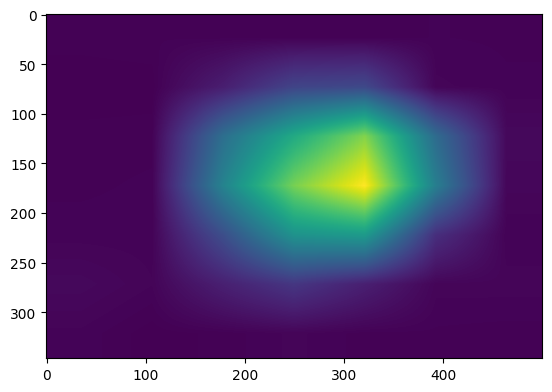

In [26]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [18]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

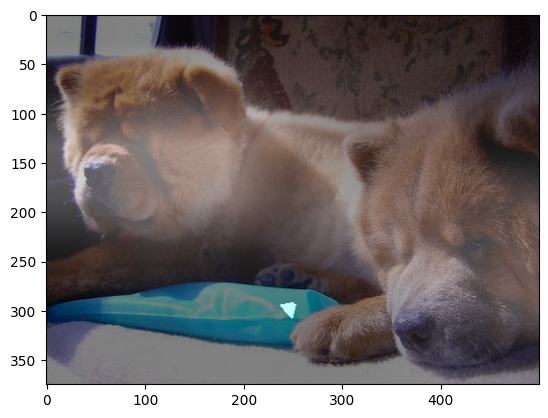

In [19]:
# opencv는 unit8 사용 -> cv2.addWeighted 사용하기 위해 변환 
origin_image = item['image'].astype(np.uint8) 
# 0~1로 만든 cam_image를 0~255로 변경
# RGB 채널에 맞춰 3개의 채널로 복사
# [cam_image_scaled, cam_image_scaled, cam_image_scaled] -> axis=-1로 마지막 축에 새로운 차원을 추가 
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# Grad-Cam 만들기
- 앞서 만든 cam을 활용함

80


2024-07-05 03:41:30.450932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


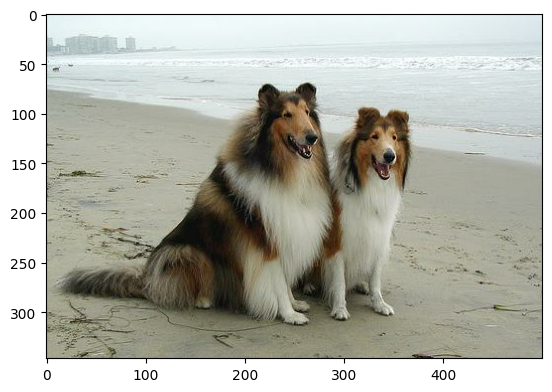

In [20]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [29]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model(model.inputs, [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        # 정확하게 이해는 못했지만, loss가 왔을때, conv_output의 미분값 (gradient)가 오는 듯 함 -현재 모델의 가중치는 고정된 상태
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

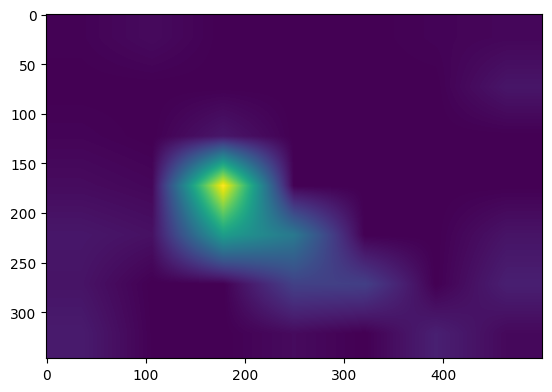

In [30]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

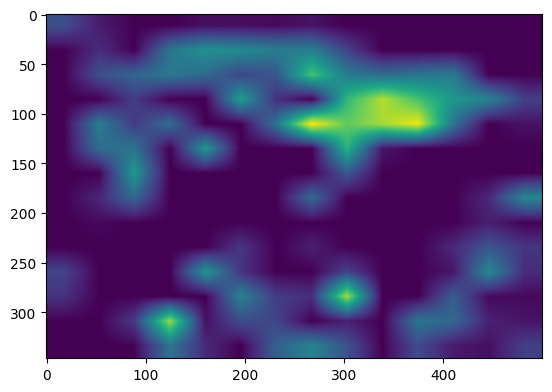

In [31]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

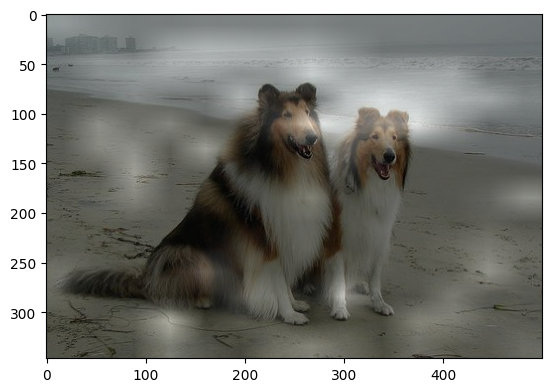

In [33]:
# opencv는 unit8 사용 -> cv2.addWeighted 사용하기 위해 변환 
origin_image = item['image'].astype(np.uint8) 
# 0~1로 만든 cam_image를 0~255로 변경
# RGB 채널에 맞춰 3개의 채널로 복사
# [cam_image_scaled, cam_image_scaled, cam_image_scaled] -> axis=-1로 마지막 축에 새로운 차원을 추가 
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# CAM에서 물체의 위치를 찾는 detection

40


2024-07-05 06:00:40.650637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


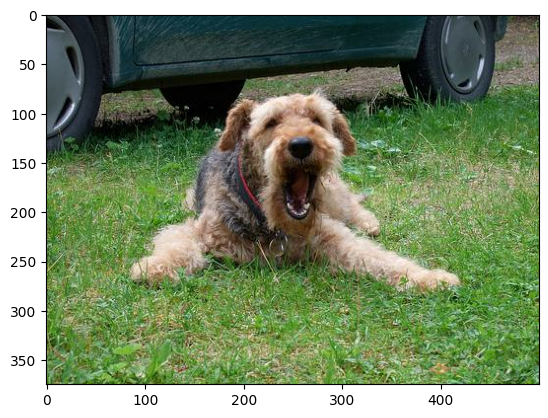

In [38]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

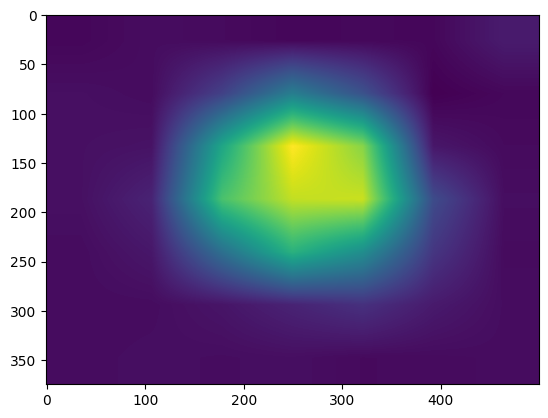

In [39]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [40]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    # cv2.findContours: 이진화된 이미지를 입력으로 받아 이미지에서 외곽선(컨투어)을 찾습니다.
        # cam_image: 이진화된 이미지.  
        # cv2.RETR_TREE: 모든 컨투어를 계층 구조로 검색합니다.
        # cv2.CHAIN_APPROX_SIMPLE: 컨투어 포인트들을 단순화합니다
    # 외곽선을 여러개 찾는 듯. 첫번째 것 (가장 주요한 것?) 만 사용
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    # cv2.minAreaRect: 주어진 포인트 집합(컨투어)을 감싸는 최소 면적의 회전된 직사각형을 계산합니다.
        # rotated_rect는 (center (x, y), (width, height), angle of rotation)을 반환
        # 회전된 직사각형이여서, 이미지를 뚫고 나가면 음수값이 나올 수 있음 
    rotated_rect = cv2.minAreaRect(cnt)
    # cv2.boxPoints(rotated_rect): 회전된 직사각형의 네 꼭지점 좌표를 계산합니다.
    # np.int0(rect): 좌표를 정수로 변환합니다.
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [41]:
rect = get_bbox(cam_image)
rect

/tmp/ipykernel_89739/770630722.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect = np.int0(rect)


array([[ 64, 262],
       [135,  -8],
       [478,  81],
       [407, 352]])

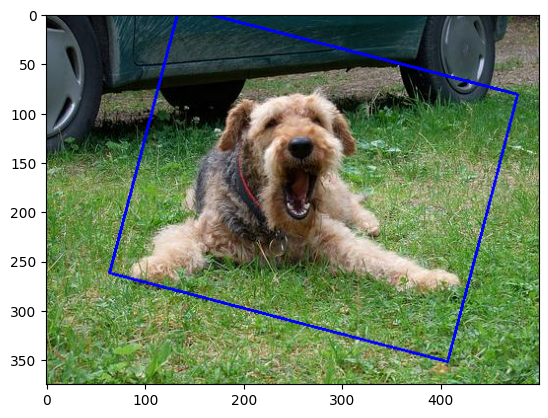

In [48]:
image = copy.deepcopy(item['image'])
# cv2.drawContours: 이미지에 외곽선을 그립니다.
    # image: 외곽선을 그릴 이미지
    # contours: 외곽선 좌표 (리스트로 받을 수 있음 -> 여러개의 외곽선을 그릴 수 있음)
    # contourIdx: 외곽선 인덱스, -1이면 모든 외곽선을 그립니다., 0이면 첫번째 외곽선을 그립니다., 1이면 두번째 외곽선을 그립니다. 
    # color: 외곽선 색상
    # thickness: 외곽선 두께
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

# detect한 박스의 IOU 계산

In [43]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min = rect의 y좌표 최소값 / 이미지 y축 크기(높이) = normalized된 y_min 좌표값
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [44]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.021333333333333333, 0.128, 0.9386666666666666, 0.956]

In [45]:
# 정답 bbox
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

In [46]:
# 정답 bbox와 예측 bbox의 IoU 계산
def get_iou(boxA, boxB):
    # 교차 영역 좌표 계산
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    # 교차 영역의 넓이 계산
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    # 각 bbox의 넓이 계산
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [47]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.4787640661097187